In [357]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
import json
from numpyencoder import NumpyEncoder #by Hunter M. Allen (https://pypi.org/project/numpyencoder/)
from astropy.io import ascii
from matplotlib import colors



param_path = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\params_good.txt'
param_df = pd.read_csv(param_path, sep=",")

refmag_path = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\refmags_good.txt'
refmag_df = pd.read_csv(refmag_path, sep=",")

param_df.columns

Index(['ZTF_ID', 'F_p', 'F_p_err', 't_0', 't_0_err', 'sigma_rise',
       'sigma_rise_err', 'tau_dec', 'tau_dec_err', 'T', 'T_err', 'F_0g',
       'F_0g_err', 'F_0r', 'F_0r_err', 'log10_F_p', 'log10_F_p_err',
       'log10_sigma_rise', 'log10_sigma_rise_err', 'log10_tau_dec',
       'log10_tau_dec_err', 'log10_T', 'log10_T_err', 'nu_0', 't0_cc', 'Fp_cc',
       'chi2_dof'],
      dtype='object')

In [358]:
sigma_rise = param_df['sigma_rise'].to_numpy()
tau_dec = param_df['tau_dec'].to_numpy()

sigma_rise_err = param_df['sigma_rise_err'].to_numpy()

#rules for filtering out bad fits
bad_log10sigma_error_mask = param_df['log10_sigma_rise_err'] < 0.2 
bad_log10tau_error_mask = param_df['log10_tau_dec_err'] <  0.2

param_df = param_df[bad_log10sigma_error_mask * bad_log10tau_error_mask]
refmag_df = refmag_df[bad_log10sigma_error_mask * bad_log10tau_error_mask]
print(param_df.shape)

(9727, 27)


In [363]:


#Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
g_center = c/ (4746.48 * 1e-10)
r_center = c / (6366.38 * 1e-10)
i_center = c / (7867.41 * 1e-10)

# def temp_correct():

lancel_idx = param_df['ZTF_ID'] == 'ZTF19aaejtoy'
lancel_ref_idx = refmag_df['ZTF_ID'] == 'ZTF19aaejtoy'
lancel_fp = param_df['F_p'][lancel_idx].values[0]
# print(param_df['nu_0'][lancel_idx])
# print(param_df['T'][lancel_idx])
# print('here')
green_correction = BB_ratio(param_df['T'][lancel_idx].values[0],g_center,param_df['nu_0'][lancel_idx].values[0])
red_correction = BB_ratio(param_df['T'][lancel_idx].values[0],r_center,param_df['nu_0'][lancel_idx].values[0])


lancel_dm = sjoert.stellar.flux2mag(lancel_fp *1e-6 * green_correction) - refmag_df['refmag_g'].values[lancel_ref_idx]
lancel_dmr = sjoert.stellar.flux2mag(lancel_fp *1e-6 * red_correction) - refmag_df['refmag_r'].values[lancel_ref_idx]
print(lancel_dm[0])
print(lancel_dmr[0])
print(lancel_fp * green_correction)
print(lancel_fp * red_correction)

# lancel_diff = diff_g[lancel_idx][0]
# lancel_diffparam_df['sigma_rise'][lancel_idx].values[0], param_df['tau_dec'][lancel_idx].values[0]

0.7498052897936489
1.0010274008348894
687.5079804023451
968.2530662428093


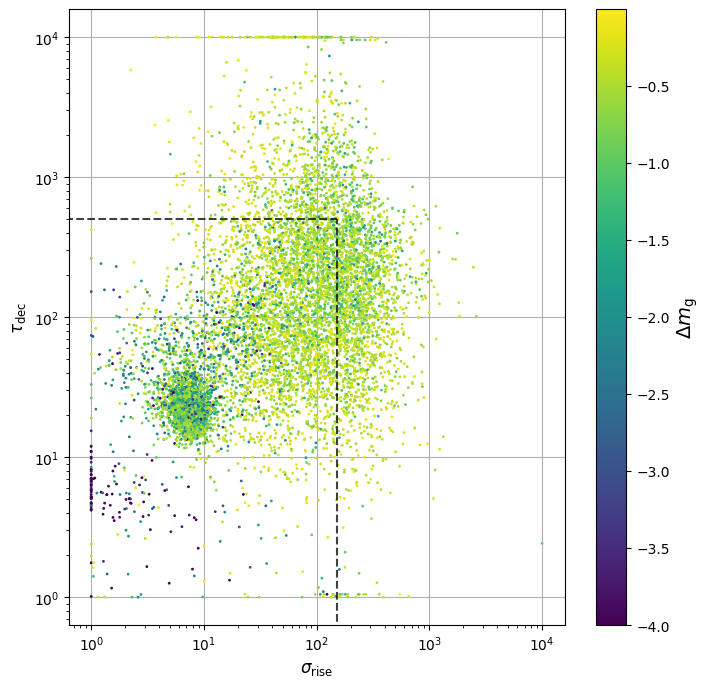

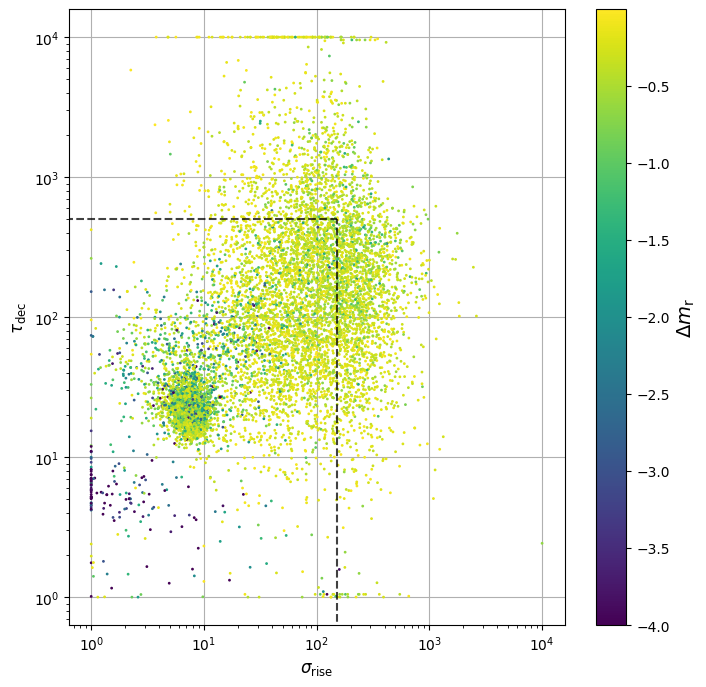

In [ ]:
param_label_dict = {'sigma_rise':r'$\sigma_{\text{rise}}$','tau_dec':r'$\tau_{\text{dec}}$',
                    'log10_sigma_rise':r'$\sigma_{\text{rise}}$','log10_tau_dec':r'$\tau_{\text{dec}}$',
                    'F_p':r'F$_{\text{peak}}$','peak_g':r'F$_{\text{p,g}}$','peak_r':r'F$_{\text{p,r}}$'}

def param_scatterplot(data,param1,param2,colorby = None,colorby_label='',colorbar=True,logspace=True,mask=0,boundaries=True):
    param1data = data[param1].to_numpy()
    param2data = data[param2].to_numpy()
    
    if type(mask) == int: mask = np.ones(param1data.shape).astype(bool)
    param1data = param1data[mask]
    param2data = param2data[mask]

    try:
        #if the parameter has an error (which most always the case for relevant parameters) get that as well
        if logspace:
            param1data_err = data['log10_'+param2+'_err'][mask]
        else:
            param1data_err = data[+param2+'_err'][mask]
            # param1data_err = 1/np.log(10) * param_df[param1+'_err'] / param1data
        param1errFlag = True
    except KeyError:
        param1errFlag = False

    try:
        #if the parameter has an error (which most always the case for relevant parameters) get that as well
        if logspace:
            param2data_err = data['log10_'+param2+'_err'][mask]
        else:
            param2data_err = data['log10_'+param2+'_err'][mask]
        # param2data_err = 1/np.log(10) * param_df[param2+'_err'] / param2data
        param2errFlag = True
    except KeyError:
        param2errFlag = False

    # param1errFlag = False
    # param2errFlag = False
    fig,ax = plt.subplots(figsize=(8,8))
    if param1errFlag:
        if param2errFlag:
            if colorby is not None:
                if colorbar:
                    # ax.errorbar(param1data,param2data,xerr=param1data_err,yerr=param2data_err,fmt=',',capsize=1,color='black')
                    colorscatter = ax.scatter(param1data,param2data,c=np.clip(colorby[mask],-4,4),cmap='viridis',s=1,zorder=10)
                    clbr = fig.colorbar(colorscatter)
                    clbr.set_label(colorby_label,fontsize=14)
                else:
                    colorby = colorby[mask]
                    colordict = {"AGN":'gray',"SN":"green","TDE":'blue','Unknown':'red'}
                    markerdict = {"AGN":'s',"SN":"o","TDE":'P','Unknown':'p'}
                    for elem in np.unique(colorby):
                        colormask = (colorby == elem)
                        if elem == 'Unknown':
                            ax.scatter(param1data[colormask],param2data[colormask],edgecolors=colordict[elem],marker=markerdict[elem],s=10,zorder=1,label=elem,alpha=0.5,facecolors='none')
                        else:
                            ax.scatter(param1data[colormask],param2data[colormask],edgecolors=colordict[elem],marker=markerdict[elem],s=15,zorder=10,label=elem,facecolors='none')

            else:
                ax.errorbar(param1data,param2data,xerr=param1data_err,yerr=param2data_err,fmt=',',capsize=4,color='black')
        else:
            ax.errorbar(param1data,param2data,xerr=param1data_err,fmt='.',capsize=2)
    else:
        if param2errFlag:
            ax.errorbar(param1data,param2data,yerr=param2data_err,fmt='.',capsize=2)
        else:
            ax.scatter(param1data,param2data,s=4)
    ax.set_xlabel(param_label_dict[param1],fontsize=12)
    ax.set_ylabel(param_label_dict[param2],fontsize=12)
    #plt.savefig(param1+'_vs_'+param2+'.png',dpi=600)
    ax.set(xscale="log",yscale='log')
    ax.grid()
    if colorbar == False:
        ax.legend()
    if boundaries:
        ax.vlines(150,0,500,colors='black',linestyles='dashed',zorder=10,alpha=0.75)
        ax.hlines(500,0,150,colors='black',linestyles='dashed',zorder=10,alpha=0.75)
    plt.show()

# norm = plt.Normalize()
# colors = plt.cm.jet(norm(diff_g))

param_scatterplot(param_df,'sigma_rise','tau_dec',diff_g,r'$\Delta m_{\text{g}}$')
param_scatterplot(param_df,'sigma_rise','tau_dec',diff_r,r'$\Delta m_{\text{r}}$')


In [ ]:
sigma_rise = param_df['log10_sigma_rise']
sigma_rise_err = param_df['log10_sigma_rise_err']
tau_dec = param_df['log10_tau_dec']
tau_dec_err = param_df['log10_tau_dec_err']

2077


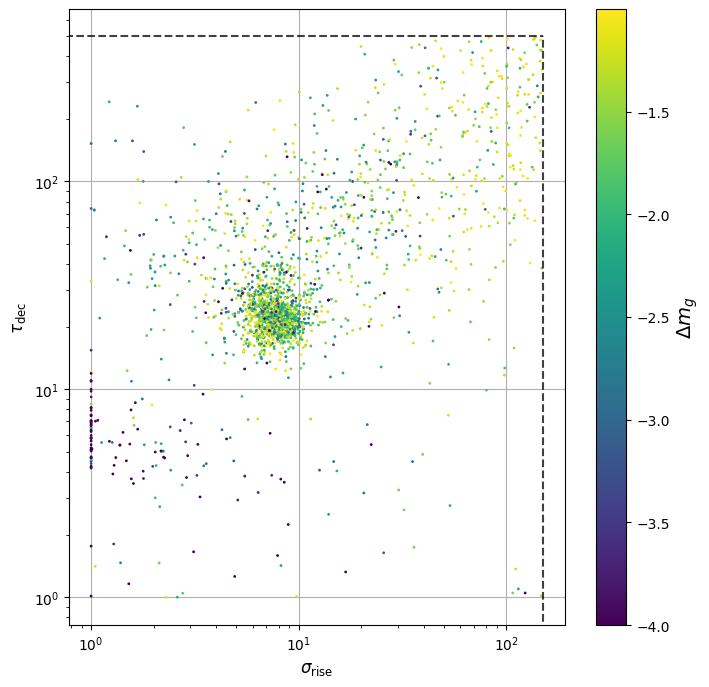

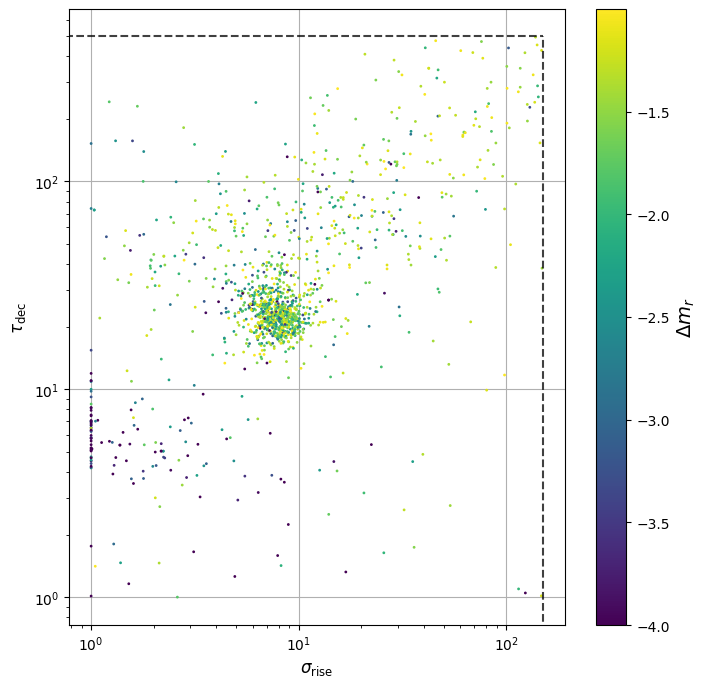

In [ ]:
delta_m_selection_g = (diff_g <= -1) & (sigma_rise < np.log10(150)) & (tau_dec < np.log10(500)) 
delta_m_selection_r = (diff_r <= -1) & (sigma_rise < np.log10(150)) & (tau_dec < np.log10(500)) 
print(delta_m_selection_g.sum())
param_scatterplot(param_df,'sigma_rise','tau_dec',colorby=diff_g,colorby_label=r'$\Delta m_g$',mask=delta_m_selection_g)
param_scatterplot(param_df,'sigma_rise','tau_dec',colorby=diff_r,colorby_label=r'$\Delta m_r$',mask=delta_m_selection_r)

In [ ]:
class_info = ascii.read(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\relevant_class_info.dat')

In [ ]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])
perm_indx = class_info['ztf_id'].argsort()
class_info = class_info[perm_indx]
is_sorted(class_info['ztf_id'])

True

In [ ]:
ztfmask2 = np.isin(np.array(param_df['ZTF_ID']),np.array(class_info['ztf_id']))

In [ ]:
paramztfs = np.array(param_df['ZTF_ID'],dtype='<U12')[ztfmask2]
if not is_sorted(paramztfs):
    paramztfs.sort()
param_df_masked = param_df[ztfmask2]
print(param_df_masked.shape)
class_info

(9594, 27)


ztf_id,MBH,MBH_ref,classification
str12,float64,str20,str7
ZTF17aaaduqw,0.0,--,Unknown
ZTF17aaaeqnq,0.0,--,Unknown
ZTF17aaahzsk,0.0,--,Unknown
ZTF17aaailvv,0.0,--,Unknown
ZTF17aaajazz,7.181944640982347,T13,Unknown
ZTF17aaakeyg,0.0,--,Unknown
ZTF17aaanztg,7.290675565761776,T13,Unknown
ZTF17aaapufz,0.0,--,Unknown
ZTF17aaazdba,6.143470608259163,Yao et al. 2023arXiv,TDE


In [ ]:
delta_m_selection_g_masked = (diff_g[ztfmask2] <= -1) & (param_df_masked['log10_sigma_rise'].to_numpy() < 150) & (param_df_masked['log10_tau_dec'] < 500) 
delta_m_selection_r_masked = (diff_r[ztfmask2] <= -1) & (param_df_masked['log10_sigma_rise'].to_numpy() < 150) & (param_df_masked['log10_tau_dec'] < 500) 

In [ ]:
print(np.sum(delta_m_selection_g))
print(np.sum(delta_m_selection_r))

2077
1346


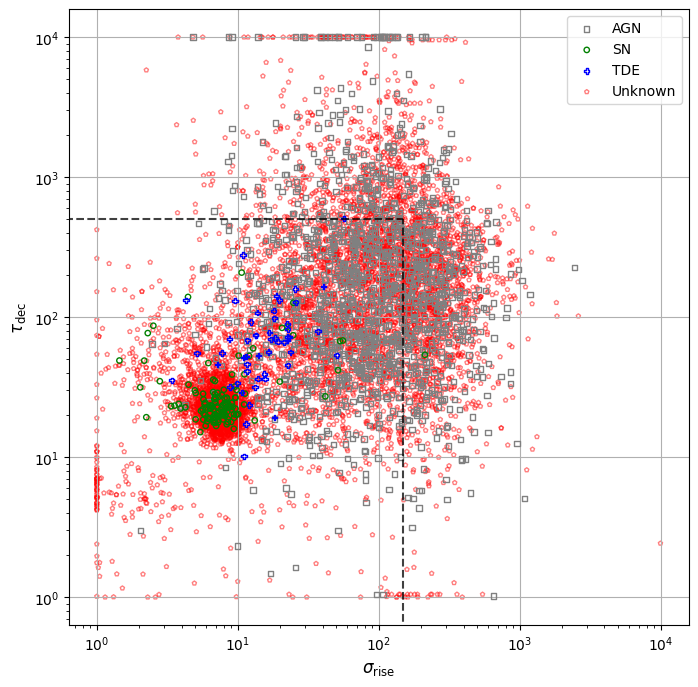

In [ ]:
param_scatterplot(param_df_masked,'sigma_rise','tau_dec',colorby=np.array(class_info['classification']),colorbar=False,mask=0)

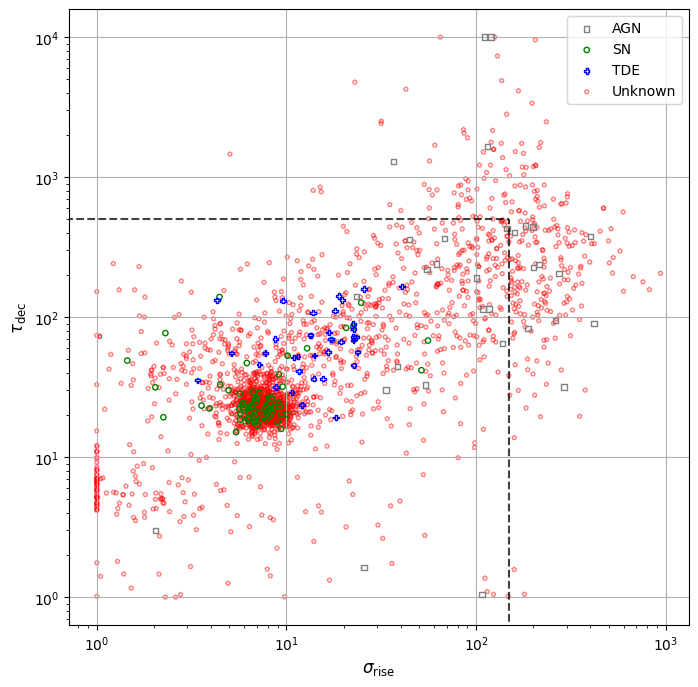

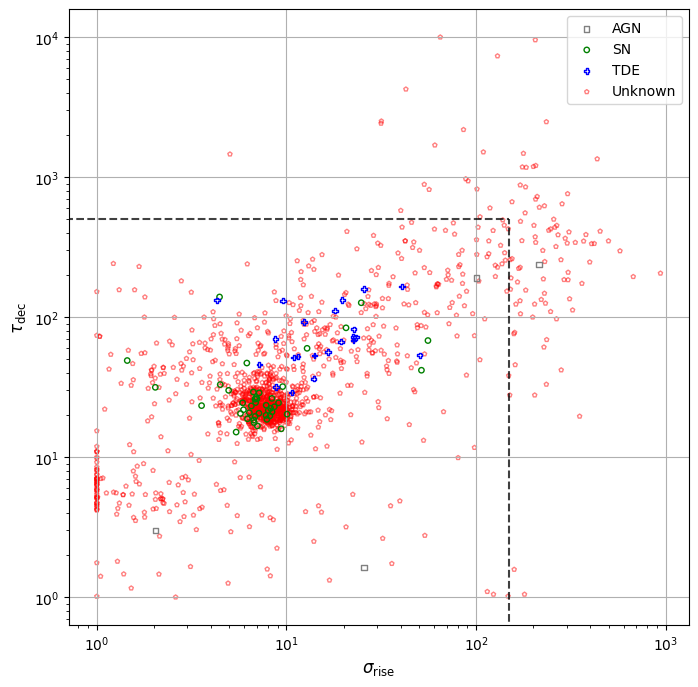

In [ ]:
param_scatterplot(param_df_masked,'sigma_rise','tau_dec',colorby=np.array(class_info['classification']),colorbar=False,mask=delta_m_selection_g_masked)
param_scatterplot(param_df_masked,'sigma_rise','tau_dec',colorby=np.array(class_info['classification']),colorbar=False,mask=delta_m_selection_r_masked)

In [ ]:
param_df_masked

,ZTF_ID,F_p,F_p_err,t_0,t_0_err,sigma_rise,sigma_rise_err,tau_dec,tau_dec_err,T,...,log10_sigma_rise,log10_sigma_rise_err,log10_tau_dec,log10_tau_dec_err,log10_T,log10_T_err,nu_0,t0_cc,Fp_cc,chi2_dof
3,ZTF17aaaduqw,219.434005,2.806427,1395.628138,0.049080,1.000000,0.032199,8.130487,0.217803,17685.838216,...,8.958150e-20,0.013984,0.910117,0.011634,4.247626,0.023393,5.176176e+14,1400.446887,91.977888,2.661822
6,ZTF17aaaeqnq,128.954176,0.534305,931.875050,0.398707,240.704303,0.852044,45.071658,0.461969,3113.804140,...,2.381484e+00,0.001537,1.653904,0.004451,3.493291,0.001270,5.380230e+14,883.453889,56.739378,64.429592
8,ZTF17aaahzsk,74.321185,15.831012,-45.551576,0.773026,24.948756,0.906147,4.494737,1.186848,4359.925501,...,1.397049e+00,0.015774,0.652704,0.114677,3.639479,0.094523,5.419487e+14,204.488287,103.166691,201.641352
10,ZTF17aaailvv,787.557974,19.160123,284.149175,0.120280,1.000000,0.216918,6.318933,0.105938,9942.117461,...,3.543569e-11,0.094206,0.800644,0.007281,3.997479,0.013881,4.979960e+14,287.505185,489.745605,69.043279
12,ZTF17aaajazz,72.394866,3.368313,921.481344,4.318740,45.646267,2.551618,87.808999,5.938567,5149.208162,...,1.659405e+00,0.024277,1.943539,0.029372,3.711740,0.016650,5.333787e+14,902.516516,217.563098,38.469161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13454,ZTF23aadcizn,52.913864,0.338300,1603.388489,2.342658,128.332120,1.823137,262.182543,9.896316,10913.515062,...,2.108335e+00,0.006170,2.418604,0.016393,4.037965,0.006597,5.474001e+14,1459.274618,26.567646,1.731830
13458,ZTF23aadqcax,42.739836,1.066830,1430.680846,5.905980,65.862075,3.536435,312.906476,12.275838,6259.008454,...,1.818635e+00,0.023319,2.495415,0.017038,3.796506,0.007461,5.249961e+14,1347.180532,44.809255,8.538360
13459,ZTF23aadrbcb,195.100677,0.960945,1395.721084,0.731974,46.296317,0.506629,562.970231,7.906743,14738.104918,...,1.665546e+00,0.004753,2.750485,0.006100,4.168442,0.005131,5.490996e+14,1399.319329,165.385608,12.000672
13464,ZTF23aadtqpv,10.522187,0.000000,-389.625901,0.000000,9990.793843,0.000000,2.423643,0.000000,27120.899787,...,3.999600e+00,0.000000,0.384469,0.000000,4.433304,0.000000,5.423264e+14,-47.806921,1.396322,0.682149


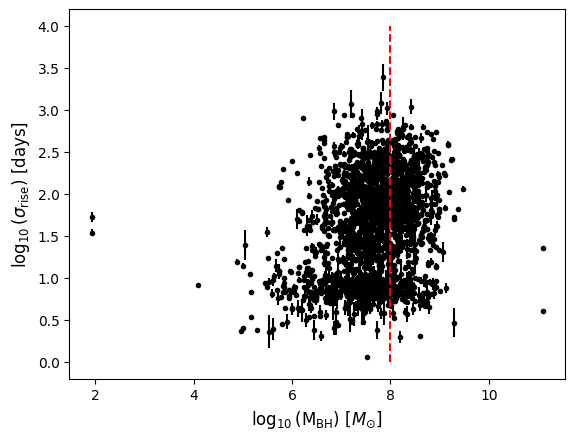

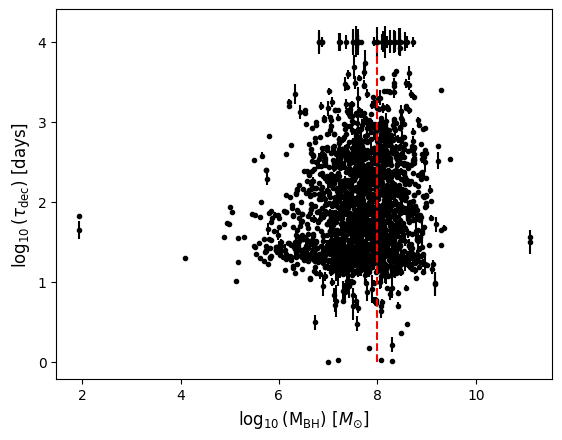

In [ ]:
mbhindx = np.nonzero(class_info['MBH'])
MBH = np.array(class_info['MBH'][mbhindx])

plt.figure()
plt.ylabel(r'$\log_{10}\left(\sigma_{\text{rise}}\right)$ [days]',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH,param_df_masked['log10_sigma_rise'].to_numpy()[mbhindx],yerr=param_df_masked['log10_sigma_rise_err'].to_numpy()[mbhindx],fmt='.',c='black')
plt.vlines(8,0,4,zorder=10,colors='red',linestyle='dashed')
plt.show()

plt.figure()
plt.ylabel(r'$\log_{10}\left(\tau_{\text{dec}}\right)$ [days]',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH,param_df_masked['log10_tau_dec'].to_numpy()[mbhindx],yerr=param_df_masked['log10_tau_dec_err'].to_numpy()[mbhindx],fmt='.',c='black')
plt.vlines(8,0,4,zorder=10,colors='red',linestyle='dashed')
plt.show()


(2148,)


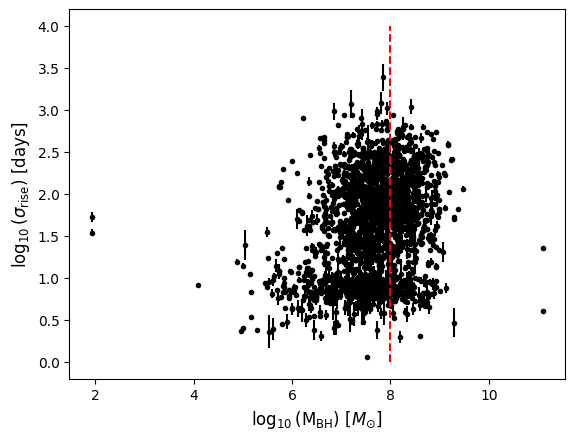

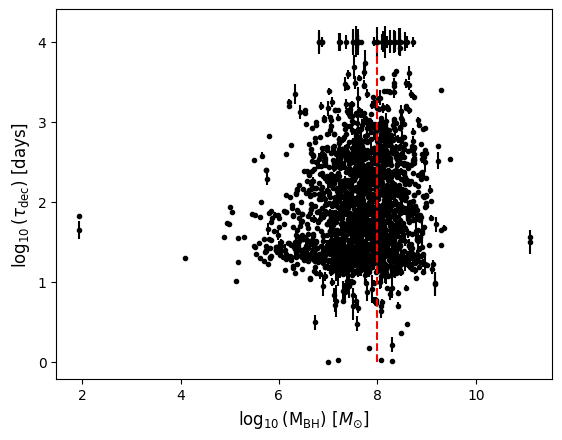

In [ ]:
MBH2 = np.array(class_info['MBH'])[delta_m_selection_g_masked]
mbhindx2 = np.nonzero(MBH)
MBH2 = MBH[mbhindx2]
print(MBH2.shape)
# print(np.nonzero(class_info['MBH'][delta_m_selection_g_masked]))
plt.figure()
plt.ylabel(r'$\log_{10}\left(\sigma_{\text{rise}}\right)$ [days]',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH2,param_df_masked['log10_sigma_rise'].to_numpy()[mbhindx],yerr=param_df_masked['log10_sigma_rise_err'].to_numpy()[mbhindx],fmt='.',c='black')
plt.vlines(8,0,4,zorder=10,colors='red',linestyle='dashed')
plt.show()

plt.figure()
plt.ylabel(r'$\log_{10}\left(\tau_{\text{dec}}\right)$ [days]',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH2,param_df_masked['log10_tau_dec'].to_numpy()[mbhindx],yerr=param_df_masked['log10_tau_dec_err'].to_numpy()[mbhindx],fmt='.',c='black')
plt.vlines(8,0,4,zorder=10,colors='red',linestyle='dashed')
plt.show()

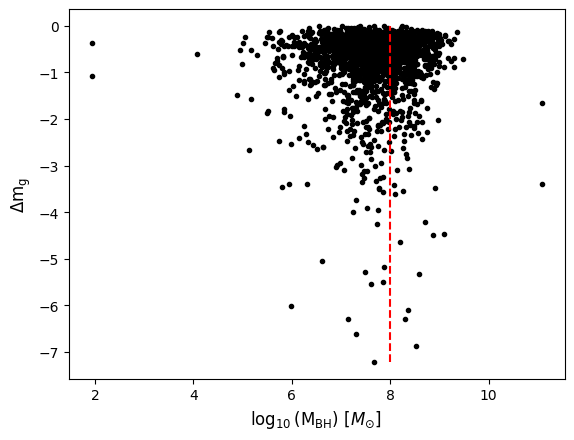

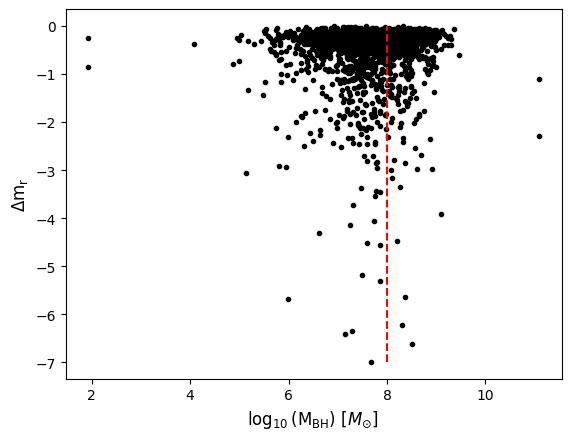

In [ ]:
diff_g_flux = sjoert.stellar.mag2flux(diff_g[ztfmask2])
diff_r_flux = sjoert.stellar.mag2flux(diff_r[ztfmask2])

plt.figure()
plt.ylabel(r'$\Delta$m$_{\text{g}}$',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH,diff_g[mbhindx],fmt='.',c='black')
plt.vlines(8,min(diff_g[mbhindx]),max(diff_g[mbhindx]),zorder=10,colors='red',linestyle='dashed')
# plt.ylim(-5,10)
plt.show()

plt.figure()
plt.ylabel(r'$\Delta$m$_{\text{r}}$',fontsize=12)
plt.xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}\right)$ $[M_{\odot}]$ ',fontsize=12)
plt.errorbar(MBH,diff_r[mbhindx],fmt='.',c='black')
plt.vlines(8,min(diff_r[mbhindx]),max(diff_r[mbhindx]),zorder=10,colors='red',linestyle='dashed')
plt.show()

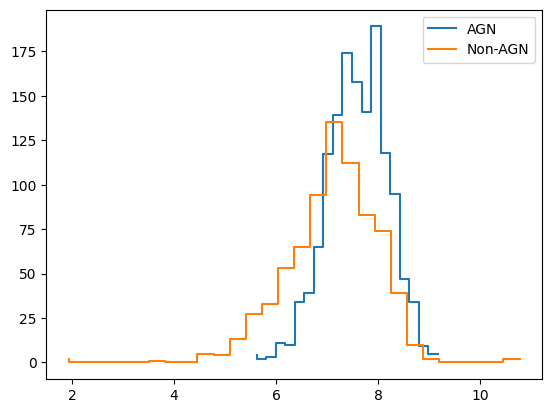

In [ ]:
AGNmask = (class_info['classification'][mbhindx] == 'AGN') #picks out all the units with given MBH of type AGN

agnmbh = class_info['MBH'][mbhindx][AGNmask]

# bins = np.linspace(np.min(class_info['MBH'][mbhindx]),np.max(class_info['MBH'][mbhindx]),20)

bins_agn,counts_agn = np.histogram(agnmbh,bins=20)
bins_nonagn,counts_nonagn = np.histogram(class_info['MBH'][mbhindx][np.invert(AGNmask)],bins=29)
# print(bins.shape,counts.shape)
plt.step(counts_agn[:-1],bins_agn,label='AGN')
plt.step(counts_nonagn[:-1],bins_nonagn,label='Non-AGN')
plt.legend()
plt.show()